In [16]:
import sys
sys.path.insert(1, "..")
import rijks_torch.learning_problems as lp
import rijks_torch.learning_problems.defaults as defs
from rijks_torch.data_loading import RijksDataloaders

import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [2]:
# Make sure model architecture corresponds to state_dict file (.pth)
getmodel_fun = lp.get_deit_b_16_problem
state_dict_file = "/home/vincent/Documenten/BachelorsProject/best_models/ots_type3_deit_b_16-best.pth"

# Make sure dataset corresponds to used model!
dataset_path = "/home/vincent/Documenten/BachelorsProject/Rijksdata/type/fullsize3"
jpg_path = "/home/vincent/Documenten/BachelorsProject/Rijksdata/jpg/"

In [14]:
# Getting dataset and model:
datloader = RijksDataloaders(
    ds_name=dataset_path,
    hist_path=dataset_path + "-hist.csv",
    img_dir=jpg_path,
    transforms={"all": defs.buildTransform(imnet_norm=True)},
    batch_size=32
)

model, dl = getmodel_fun(off_the_shelf=False, pretrained=False, dl=datloader)
model.load_state_dict(torch.load(state_dict_file, map_location=torch.device('cpu')))
model = model.eval()

In [21]:
def getAllAttentionWeights(model, image):
    """ Getting all attention weights by adding forward hooks and feeding it an image """
    att_weighs = []

    # Don't know how to remove the hooks again, so doing it this way :-p
    model_copy = deepcopy(model)

    def add_to_att_weights(module, inp, outp):
        nonlocal att_weighs
        # Taking the mean of all attention heads, but could also be max or min
        att_weighs += [outp.detach().numpy()[0].mean(axis=0)]
    
    for name, module in model_copy.named_modules():
        if "attn_drop" in name: # A timm thing. This only works for timm models ;-)
            module.register_forward_hook(add_to_att_weights)
    
    model_copy(image)
    
    return att_weighs

In [98]:
def attentionRollout(weight_matrices, discard_ratio = 0.0):
    """ Simply do matrix multiplication on all matrices to get attention rollout """
    
    result = np.identity(len(weight_matrices[0][0]))

    for A in weight_matrices:
        I = np.identity(len(A[0]))
        new_A = 0.5 * A + 0.5 * I
        threshold = np.quantile(new_A, discard_ratio)
        new_A[new_A < threshold] = 0
        new_A /= np.sum(new_A)
        result = np.matmul(new_A, result)
    
    result = result[0, 1:]
    shape = int(len(result) ** 0.5)

    return result.reshape((shape, shape))

In [93]:
img = test_img = next(iter(dl.test))[0][0]
weight_matrices = getAllAttentionWeights(model, img.unsqueeze(0))

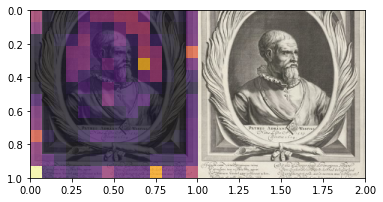

In [103]:
attention_roll = attentionRollout(weight_matrices, 0.8)

plt.imshow(invTrans(img).numpy().transpose(1,2,0), extent=(0, 1, 1, 0))
plt.imshow(invTrans(img).numpy().transpose(1,2,0), extent=(1, 2, 1, 0))
plt.xlim(left=0, right=2)
# plt.show()
plt.imshow(attention_roll, extent=(0, 1, 1, 0), alpha=0.7, cmap='inferno')
plt.show()